In [1]:
import numpy as np
import matplotlib.pyplot as plt

from algorithms.NSGA2 import nsga2
import algorithms.NSGA2.evolutionary_operators as nsga2_operators

from algorithms.MOEAD import moead, default_weight_vectors
import algorithms.MOEAD.evolutionary_operators as moead_operators

from algorithms.risk_measures import *

from data import load_stock_quotations

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

# Load data

In [2]:
stock_quotations = load_stock_quotations()

delta_t = 90
stock_returns = stock_quotations.xs('close', level=1, axis=1).pct_change()
last_returns = stock_returns[-delta_t-1:-1]

stock_returns_mean = last_returns.mean() # predicted return for next day

# variance as risk
stock_returns_var = last_returns.var() # risk
stock_returns_cov = last_returns.cov() # covariance matrix

# semi-variance as risk
stock_returns_semi_var = semi_variance(last_returns)
stock_returns_semi_cov = semi_covariance_matrix(np.array(last_returns))

number_of_stocks = stock_returns.shape[1]

# Objective function

In [3]:
def portfolio_return_value(X):
    return X @ stock_returns_mean


def portfolio_risk_var(X):
    return np.diag(X @ stock_returns_cov @ X.T)


def portfolio_risk_semi_var(X):
    return np.diag(X @ stock_returns_semi_cov @ X.T)


def portfolio_objective_function(risk_function=portfolio_risk_semi_var,
                                 return_function=portfolio_return_value):
    return lambda X: np.c_[risk_function(X), -return_function(X)]

# Test

In [4]:
def show_results(stock_risk, objective_function, moead_kwargs, nsga2_kwargs):
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.title(f"MOEA/D: iterations: {moead_kwargs['number_of_iterations']}, normalized: {moead_kwargs['normalize']}\n" +
              f"NSGA-II: iterations: {nsga2_kwargs['number_of_iterations']}, population size: {nsga2_kwargs['population_size']}")
    plt.scatter(stock_risk, stock_returns_mean, c='gray')

    moead_result = moead(objective_function=objective_function,
                         chromosome_length=number_of_stocks,
                         **moead_kwargs)

    nsga2_result = nsga2(objective_function=objective_function,
                         chromosome_length=number_of_stocks,
                         **nsga2_kwargs)

    pareto_front_moead = objective_function(moead_result)
    pareto_front_nsga2 = objective_function(nsga2_result)

    plt.scatter(pareto_front_moead[:,0], -pareto_front_moead[:,1], c='r')
    plt.scatter(pareto_front_nsga2[:,0], -pareto_front_nsga2[:,1], c='b')

    plt.legend(['Basic stocks', 'MOEA/D', 'NSGA-II'])
    plt.show()

NSGA-II: 100%|██████████| 200/200 [00:55<00:00,  3.61it/s]


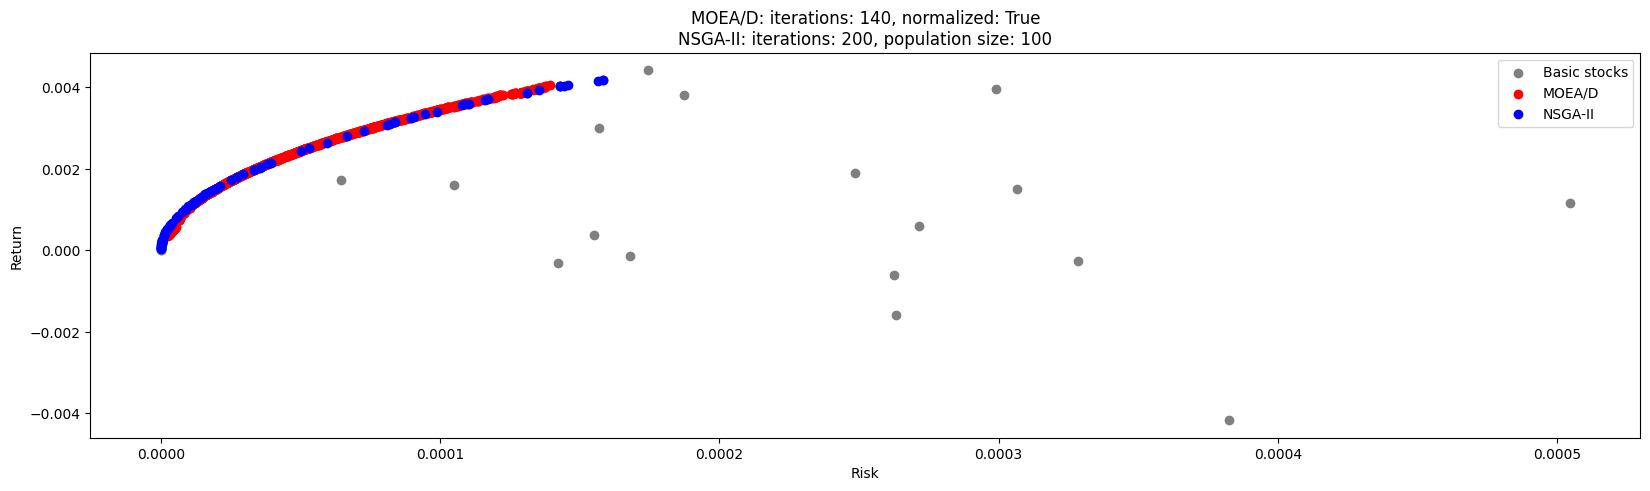

In [5]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             moead_kwargs={'number_of_iterations': 140,
                           'weight_vectors': default_weight_vectors(120),
                           'neighborhood_size': 20,
                           'mutation_probability': 0.2,
                           'normalize': True,
                           'crossover_operator': moead_operators.single_point_crossover,
                           'mutation_operator': moead_operators.swap_mutation},
             nsga2_kwargs={'population_size': 100,
                           'number_of_offspring': 200,
                           'number_of_iterations': 200,
                           'crossover_probability': 0.95,
                           'mutation_probability': 0.25,
                           'crossover_operator': nsga2_operators.differential_crossover(),
                           'mutation_operator': nsga2_operators.swap_mutation,
                           'alpha': 0.75})

NSGA-II: 100%|██████████| 1200/1200 [5:12:46<00:00, 15.64s/it] 


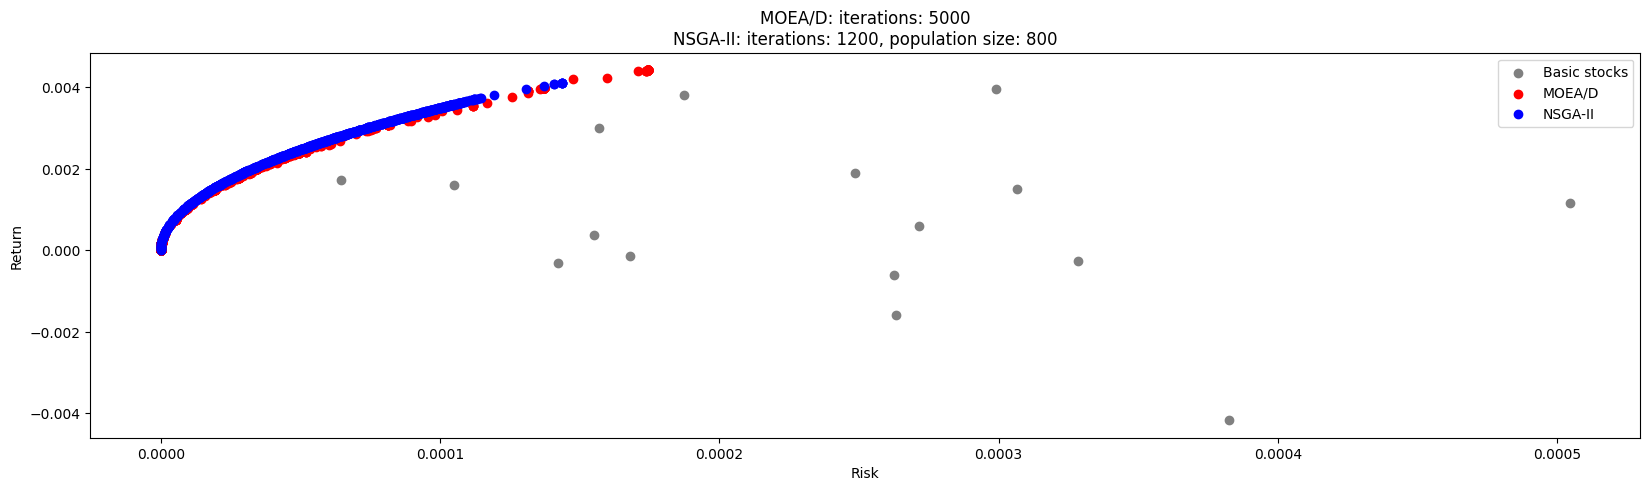

In [5]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             moead_kwargs={'number_of_iterations': 5000,
                           'weight_vectors': default_weight_vectors(250),
                           'neighborhood_size': 20,
                           'mutation_probability': 0.2,
                           'normalize': True,
                           'crossover_operator': moead_operators.single_point_crossover,
                           'mutation_operator': moead_operators.swap_mutation},
             nsga2_kwargs={'population_size': 800,
                           'number_of_offspring': 1600,
                           'number_of_iterations': 1200,
                           'crossover_probability': 0.95,
                           'mutation_probability': 0.25,
                           'crossover_operator': nsga2_operators.differential_crossover(),
                           'mutation_operator': nsga2_operators.swap_mutation,
                           'alpha': 0.75})